# Multivariate Linear Regression for Life Expectancy Prediction

This notebook provides a comprehensive, lecture-style guide to implementing multivariate linear regression from scratch. We will:

- Explain the theory behind multivariate linear regression and ordinary least squares (OLS).
- Explore a dataset containing WHO health indicators and UN economic data for 193 countries from 2000–2015.
- Implement a gradient descent solution to fit a linear model.
- Evaluate and interpret the model’s performance.
- Discuss potential improvements and extensions.

**Data Overview:**
- **Source:** WHO health indicators & UN economic data (2000–2015).
- **Target Variable:** Life Expectancy.
- **Predictors:** Various health, economic, immunization, and social factors.

By the end, you will understand how to build, train, and evaluate a multivariate linear regression model step-by-step.

### Importing Libraries and Setting Options

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set display and plotting options
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

## 1. Introduction and Theory

### What is Multivariate Linear Regression?

In **simple linear regression**, we predict a target variable $y$ based on a single predictor $x$:
$$
y = \beta_0 + \beta_1 x
$$

**Multivariate linear regression** extends this to multiple predictors $x_1, x_2, \dots, x_n$:
$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_n x_n
$$

In vectorized form:
$$
\mathbf{y} = X \boldsymbol{\beta}
$$
where:
- $\mathbf{y}$ is the vector of observed target values,
- $X$ is the matrix of features (one column per feature, one row per observation),
- $\boldsymbol{\beta}$ is the vector of parameters we want to learn.

### Ordinary Least Squares (OLS)

We choose $\boldsymbol{\beta}$ to minimize the sum of squared errors:
$$
\text{Cost}(\boldsymbol{\beta}) = \sum_{i=1}^{m}(y^{(i)} - \hat{y}^{(i)})^2
$$

The Mean Squared Error (MSE) form:
$$
J(\boldsymbol{\beta}) = \frac{1}{2m}\sum_{i=1}^{m}(y^{(i)} - X^{(i)}\boldsymbol{\beta})^2
$$

By minimizing MSE, we find parameters that provide the best linear fit to the data.

In reality, life expectancy depends on multiple factors (health, economic, environmental), making a multivariate model more suitable than a simple one-predictor model.

## 2. Data Overview and Preparation

**Dataset Description:**
- This dataset includes various health indicators (e.g., mortality, immunization rates), economic indicators (e.g., GDP), and other social factors, along with life expectancy for different countries and years.
- The target variable is `Life expectancy`.

**Tasks:**
- Load the dataset.
- Check for missing values and handle them.
- Ensure data types and consistency.
- Select features and target variable for the model.

We'll proceed with initial exploratory data analysis after loading and cleaning the data.

### Loading the Dataset and Initial Inspection

In [7]:
# Adjust the path to your dataset as needed
data_path = './data/Life Expectancy Data.csv'
df = pd.read_csv(data_path)

print("Shape of the dataset:", df.shape)
df.head()

Shape of the dataset: (2938, 22)


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


![Model Results](./images/Screenshot.png)

### Checking Missing Values and Cleaning

In [10]:
# Removes leading and trailing spaces from column names
df.columns = df.columns.str.strip()

# Check for missing values
missing_counts = df.isnull().sum()
print("Missing values per column:\n", missing_counts[missing_counts > 0])

# For simplicity, drop rows with missing values
df = df.dropna()
print("\nShape after dropping missing values:", df.shape)

# Inspect data types
print("\nData types:\n", df.dtypes)

Missing values per column:
 Life expectancy                     10
Adult Mortality                     10
Alcohol                            194
Hepatitis B                        553
BMI                                 34
Polio                               19
Total expenditure                  226
Diphtheria                          19
GDP                                448
Population                         652
thinness  1-19 years                34
thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
dtype: int64

Shape after dropping missing values: (1649, 22)

Data types:
 Country                             object
Year                                 int64
Status                              object
Life expectancy                    float64
Adult Mortality                    float64
infant deaths                        int64
Alcohol                            float64
percentage expenditure             float64
Hepati

![Model Results](./images/Screenshot1.png)

### Selecting Target and Features

In [13]:
# We will use multiple predictors including health and economic indicators.
# Target: Life expectancy
target = 'Life expectancy'

# Example features chosen for illustration:
features = [
    'Adult Mortality', 
    'infant deaths', 
    'Alcohol', 
    'GDP', 
    'Schooling', 
    'HIV/AIDS'
]

# Filter the DataFrame
df_model = df[[target] + features].dropna()

X = df_model[features].values
y = df_model[target].values.reshape(-1, 1)

print("Final shape of feature matrix:", X.shape)
print("Final shape of target vector:", y.shape)

Final shape of feature matrix: (1649, 6)
Final shape of target vector: (1649, 1)


![Model Results](./images/Screenshot2.png)

## 3. Visual Explorations

We will:
- Plot the distribution of the target variable (Life Expectancy).
- Examine boxplots of selected features to identify outliers.
- Create scatterplots to understand the relationship between features and the target.

### Visual Explorations

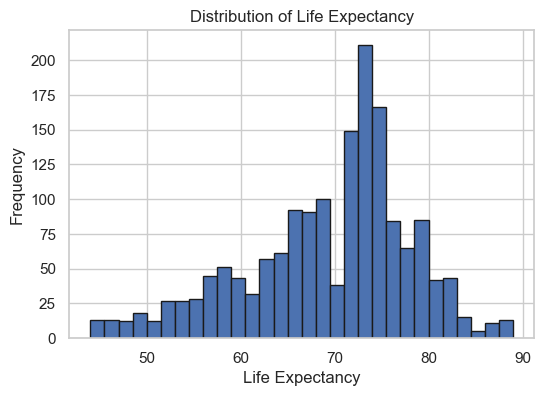

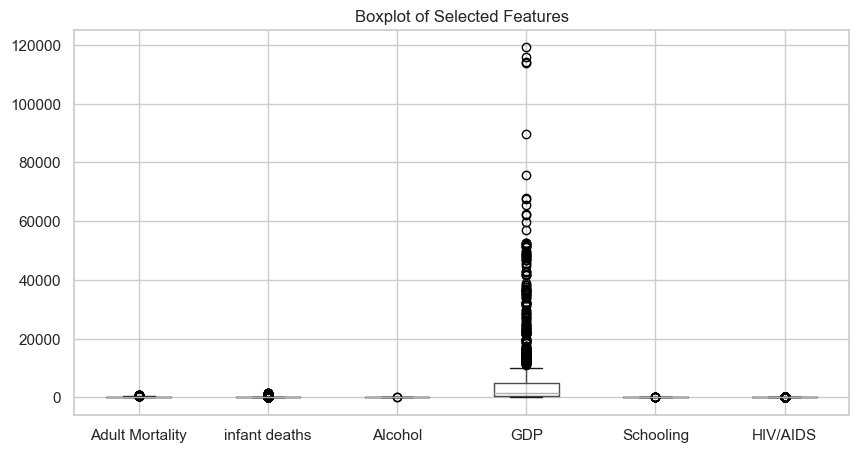

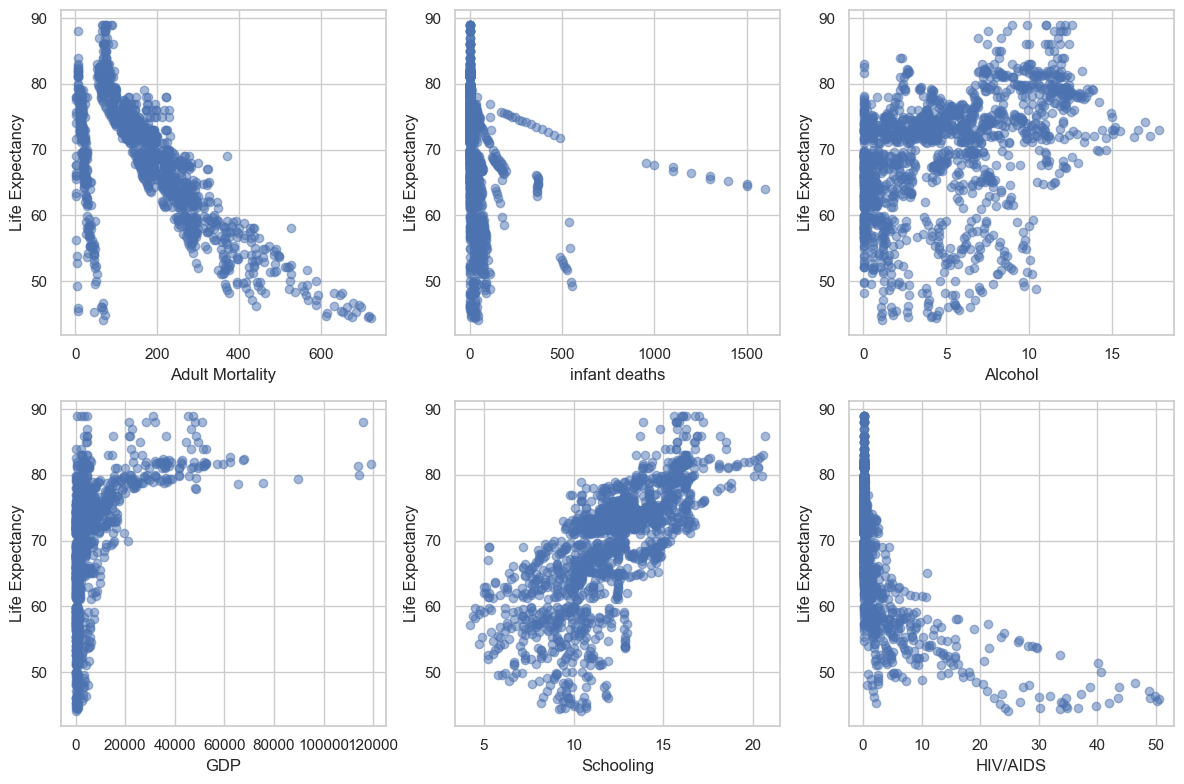

In [17]:
# Distribution of Life Expectancy
plt.figure(figsize=(6,4))
plt.hist(df_model[target], bins=30, edgecolor='k')
plt.title('Distribution of Life Expectancy')
plt.xlabel('Life Expectancy')
plt.ylabel('Frequency')
plt.show()

# Boxplots of Selected Features
plt.figure(figsize=(10,5))
df_model[features].boxplot()
plt.title('Boxplot of Selected Features')
plt.show()

# Scatterplots: Life Expectancy vs Features
fig, axes = plt.subplots(2, 3, figsize=(12,8))
axes = axes.ravel()
for i, feat in enumerate(features):
    axes[i].scatter(df_model[feat], df_model[target], alpha=0.5)
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel('Life Expectancy')
plt.tight_layout()
plt.show()

![Model Results](./images/download.png)
![Model Results](./images/download-1.png)
![Model Results](./images/download-2.png)

### Correlation Analysis

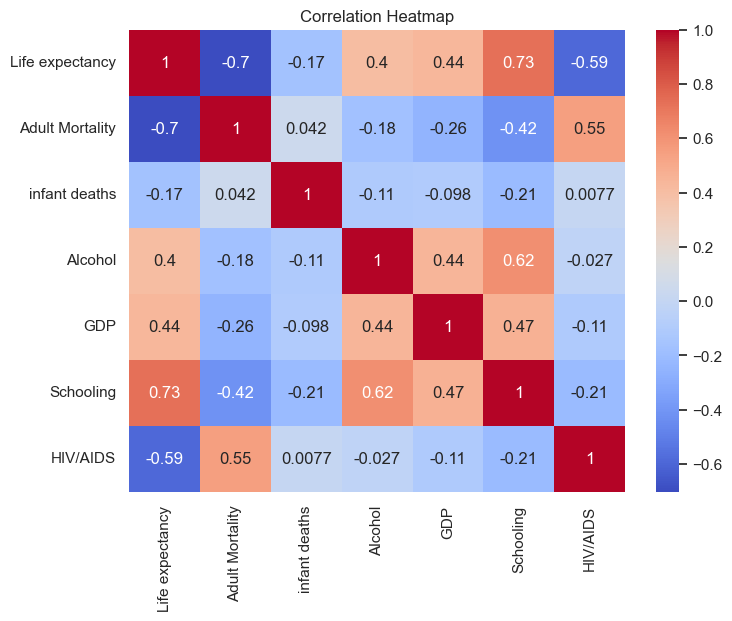

In [20]:
# Correlation Heatmap
plt.figure(figsize=(8,6))
corr_matrix = df_model.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Interpretation:
# - Strong negative correlation: Adult Mortality, HIV/AIDS with Life Expectancy
# - Strong positive correlation: Schooling, GDP with Life Expectancy
# This guides us in understanding feature importance.

![Model Results](./images/download-3.png)

## 4. Mathematical Foundations

**Mean Squared Error (MSE):**
$$
J(\boldsymbol{\beta}) = \frac{1}{2m}\sum_{i=1}^{m}(y^{(i)} - X^{(i)}\boldsymbol{\beta})^2
$$

**Gradient Descent:**
To minimize $J(\boldsymbol{\beta})$, we use gradient descent:
$$
\boldsymbol{\beta} := \boldsymbol{\beta} - \alpha \frac{1}{m} X^\top (X\boldsymbol{\beta} - y)
$$

Where $\alpha$ is the learning rate.

**Vectorization:**
Using vectorized operations speeds up computations, which is crucial for larger datasets.

## 5. Model Implementation Steps

We will:
- Scale the features for stable and efficient gradient descent.
- Add an intercept term.
- Initialize parameters randomly.
- Implement the cost and gradient descent functions.
- Run gradient descent and monitor the cost reduction.

If the cost does not decrease sufficiently, we may adjust the learning rate ($\alpha$) or the number of iterations.

In [24]:
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add intercept term
m = X_scaled.shape[0]
X_with_intercept = np.hstack([np.ones((m, 1)), X_scaled])

# Initialize parameters
np.random.seed(42)
theta = np.random.randn(X_with_intercept.shape[1], 1)

# Hyperparameters chosen based on experimentation
alpha = 9e-4
iterations = 10000

In [25]:
def compute_cost(X, y, theta):
    m = X.shape[0]
    predictions = X.dot(theta)
    errors = predictions - y
    cost = (1/(2*m)) * errors.T.dot(errors)
    return cost[0,0]

def gradient_descent(X, y, theta, alpha, iterations):
    m = X.shape[0]
    cost_history = np.zeros(iterations)
    for i in range(iterations):
        predictions = X.dot(theta)
        errors = predictions - y
        gradients = (1/m) * X.T.dot(errors)
        theta = theta - alpha * gradients
        cost_history[i] = compute_cost(X, y, theta)
    return theta, cost_history

final_theta, cost_history = gradient_descent(X_with_intercept, y, theta, alpha, iterations)
final_theta

array([[ 6.92938475e+01],
       [-2.71828136e+00],
       [-3.87391425e-01],
       [ 6.21886789e-02],
       [ 9.18854285e-01],
       [ 4.07591377e+00],
       [-2.73643079e+00]])

![Model Results](./images/Screenshot3.png)

### Plotting the Cost Reduction

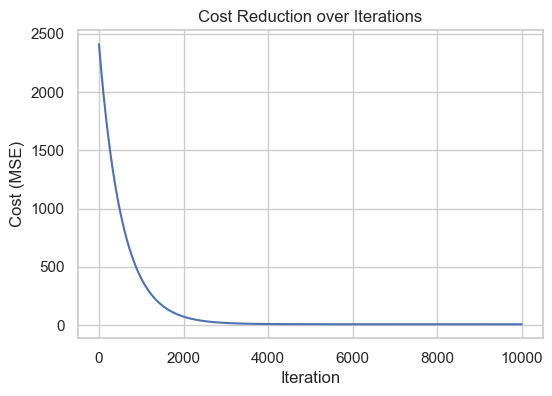

In [28]:
plt.figure(figsize=(6,4))
plt.plot(range(iterations), cost_history, 'b-')
plt.title('Cost Reduction over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Cost (MSE)')
plt.show()

# If cost plateaus near a low value, gradient descent has converged.

![Model Results](./images/download-4.png)

## 6. Model Evaluation and Prediction

We will now:
- Use `final_theta` to make predictions.
- Compute the R-squared metric to evaluate performance.
- Plot predicted vs. actual values.
- Plot residuals to check for patterns in the errors.

A higher R-squared indicates the model explains more variance in life expectancy. Residuals should ideally be randomly distributed around zero.

R-squared: 0.7968660200362521


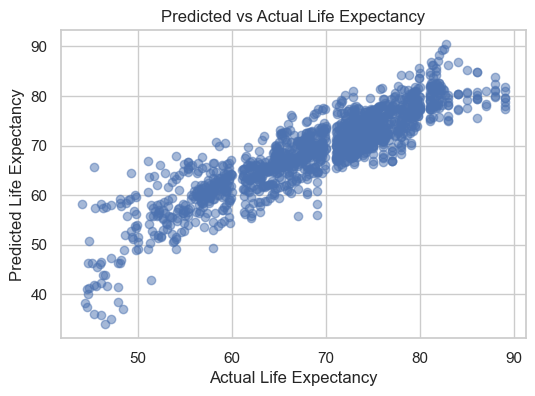

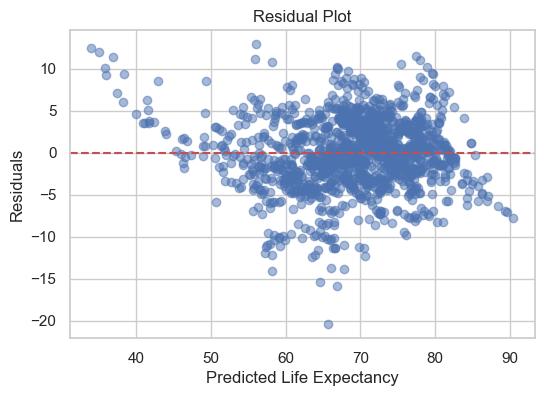

In [31]:
# Predictions
y_pred = X_with_intercept.dot(final_theta)

# Compute R-squared
ss_total = np.sum((y - np.mean(y))**2)
ss_res = np.sum((y - y_pred)**2)
r_squared = 1 - (ss_res / ss_total)
print("R-squared:", r_squared)

# Predicted vs Actual Plot
plt.figure(figsize=(6,4))
plt.scatter(y, y_pred, alpha=0.5)
plt.title('Predicted vs Actual Life Expectancy')
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.show()

# Residual Plot
residuals = y - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Life Expectancy')
plt.ylabel('Residuals')
plt.show()

![Model Results](./images/Screenshot4.png)


![Model Results](./images/download-5.png)
![Model Results](./images/download-6.png)

## 7. Explanations and Commentary

- **Model Performance:**  
  An R-squared around 0.8, for example, indicates the model explains roughly 80% of the variance in life expectancy—this is a strong result in many real-world settings.

- **Interpreting Parameters:**  
  With scaled features, each coefficient reflects how life expectancy changes with a one-standard-deviation change in that feature, holding others constant.

- **Residual Analysis:**  
  Ideally, residuals have no pattern and are centered around zero. If there's structure, consider adding non-linear terms or more features.

This linear model provides a solid baseline. More complex modeling or feature engineering could improve results further.